# **Proyecto Semestral - MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**


**Integrantes:**

- **Cristian Oyarzo M.**
- **Sebastián Quenti A.**


## **Configuración e Importación de Librerías**

En esta sección, se importarán las librerías necesarias para el desarrollo y análisis del proyecto.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

from zipfile import ZipFile
import os
import joblib

import shap


## Introducción

El proyecto se centra en el desarrollo de un modelo predictivo capaz de estimar la **probabilidad de morosidad** de los clientes de un banco. El objetivo principal es identificar aquellos clientes que son más propensos a incumplir en sus pagos, permitiendo a la institución financiera tomar decisiones informadas para gestionar riesgos y maximizar ingresos.

El conjunto de datos incluye variables relacionadas con el perfil financiero y comportamental de los clientes. Estas variables abarcan tanto datos numéricos (por ejemplo, ingresos, montos adeudados) como categóricos (por ejemplo, historial crediticio). El problema presenta un marcado desbalance entre las clases, ya que la cantidad de clientes morosos es significativamente menor en comparación con los clientes no morosos.

Dada la naturaleza desbalanceada de los datos, se seleccionó el **Área Bajo la Curva de Precisión-Recall (AUC-PR)** como métrica principal. Esta métrica es adecuada porque se centra en el rendimiento de la clase positiva (clientes morosos) y mide la capacidad del modelo para identificar correctamente a los clientes de alto riesgo mientras minimiza los falsos positivos. El uso de esta métrica es preferible frente a métricas como la precisión global (`accuracy`), que podría ser engañosa en un problema desbalanceado.

Para resolver el problema, se utilizaron cuatro modelos supervisados:
1. **XGBoost**: Un modelo basado en boosting que mostró ser el mejor entre los probados.
2. **CatBoost**: Ideal para manejar datos categóricos de forma nativa.
3. **LightGBM**: Un modelo eficiente y rápido para conjuntos de datos grandes.
4. **Regresión Logística**: Utilizada como referencia base para el análisis comparativo.

Antes del entrenamiento de los modelos, se realizaron transformaciones intermedias mediante **pipelines** y **ColumnTransformers**, que incluyeron:
- Escalado de variables numéricas.
- Codificación de variables categóricas.
- Manejo de valores faltantes, cuando fue necesario.


## **Etapa 1**

Se cargan los datos proporcionados para esta etapa del proyecto

In [3]:
df_x0 = pd.read_parquet('X_t0.parquet')
df_x1 = pd.read_parquet('X_t1.parquet')
df_y0 = pd.read_parquet('y_t0.parquet')

A continuación se listan la totalidad de variables en la base de datos:
1. **borrow_block_number**: Número de bloque en el que ocurrió el préstamo.
2. **borrow_timestamp**: Marca temporal que indica el momento del préstamo.
3. **wallet_address**: Dirección de la billetera asociada a las transacciones.
4. **first_tx_timestamp**: Fecha y hora de la primera transacción registrada de la billetera.
5. **last_tx_timestamp**: Fecha y hora de la última transacción registrada de la billetera.
6. **wallet_age**: Tiempo de existencia de la billetera en días.
7. **incoming_tx_count**: Cantidad total de transacciones entrantes a la billetera.
8. **outgoing_tx_count**: Cantidad total de transacciones salientes desde la billetera.
9. **net_incoming_tx_count**: Diferencia neta entre transacciones entrantes y salientes.
10. **total_gas_paid_eth**: Suma total de gas pagado en Ethereum (ETH) por la billetera.
11. **avg_gas_paid_per_tx_eth**: Promedio de gas pagado por transacción en ETH.
12. **risky_tx_count**: Cantidad de transacciones clasificadas como riesgosas.
13. **risky_unique_contract_count**: Número único de contratos asociados con transacciones riesgosas.
14. **risky_first_tx_timestamp**: Marca temporal de la primera transacción riesgosa registrada.
15. **risky_last_tx_timestamp**: Marca temporal de la última transacción riesgosa registrada.
16. **risky_first_last_tx_timestamp_diff**: Diferencia de tiempo entre la primera y la última transacción riesgosa.
17. **risky_sum_outgoing_amount_eth**: Suma total de ETH saliente en transacciones riesgosas.
18. **outgoing_tx_sum_eth**: Suma total de ETH saliente en todas las transacciones.
19. **incoming_tx_sum_eth**: Suma total de ETH entrante en todas las transacciones.
20. **outgoing_tx_avg_eth**: Promedio de ETH saliente por transacción.
21. **incoming_tx_avg_eth**: Promedio de ETH entrante por transacción.
22. **max_eth_ever**: Máximo balance en ETH registrado en la billetera.
23. **min_eth_ever**: Mínimo balance en ETH registrado en la billetera.
24. **total_balance_eth**: Balance total actual de la billetera en ETH.
25. **risk_factor**: Factor de riesgo calculado para la billetera.
26. **total_collateral_eth**: Colateral total en ETH asociado a la billetera.
27. **total_collateral_avg_eth**: Promedio de colateral total en ETH.
28. **total_available_borrows_eth**: Cantidad total de ETH disponible para préstamos.
29. **total_available_borrows_avg_eth**: Promedio de ETH disponible para préstamos.
30. **avg_weighted_risk_factor**: Promedio ponderado del factor de riesgo.
31. **risk_factor_above_threshold_daily_count**: Número de días en que el factor de riesgo estuvo por encima de un umbral.
32. **avg_risk_factor**: Promedio general del factor de riesgo.
33. **max_risk_factor**: Valor máximo del factor de riesgo registrado.
34. **borrow_amount_sum_eth**: Suma total de los montos prestados en ETH.
35. **borrow_amount_avg_eth**: Promedio de los montos prestados en ETH.
36. **borrow_count**: Número total de transacciones de préstamo.
37. **repay_amount_sum_eth**: Suma total de los montos reembolsados en ETH.
38. **repay_amount_avg_eth**: Promedio de los montos reembolsados en ETH.
39. **repay_count**: Número total de transacciones de reembolso.
40. **borrow_repay_diff_eth**: Diferencia entre el monto prestado y el reembolsado en ETH.
41. **deposit_count**: Número total de depósitos realizados.
42. **deposit_amount_sum_eth**: Suma total de los depósitos en ETH.
43. **time_since_first_deposit**: Tiempo transcurrido desde el primer depósito registrado.
44. **withdraw_amount_sum_eth**: Suma total de los retiros en ETH.
45. **withdraw_deposit_diff_if_positive_eth**: Diferencia positiva entre retiros y depósitos en ETH.
46. **liquidation_count**: Número total de liquidaciones registradas.
47. **time_since_last_liquidated**: Tiempo transcurrido desde la última liquidación.
48. **liquidation_amount_sum_eth**: Suma total en ETH liquidada.
49. **market_adx**: Índice direccional promedio del mercado.
50. **market_adxr**: Índice direccional promedio suavizado del mercado.
51. **market_apo**: Oscilador del precio promedio del mercado.
52. **market_aroonosc**: Oscilador de Aroon para el mercado.
53. **market_aroonup**: Valor de Aroon-Up del mercado.
54. **market_atr**: Rango verdadero promedio del mercado.
55. **market_cci**: Índice de canal de productos básicos del mercado.
56. **market_cmo**: Oscilador de momento de Chande del mercado.
57. **market_correl**: Correlación del mercado.
58. **market_dx**: Índice direccional del mercado.
59. **market_fastk**: Componente rápido K del estocástico del mercado.
60. **market_fastd**: Componente rápido D del estocástico del mercado.
61. **market_ht_trendmode**: Modo de tendencia Hilbert del mercado.
62. **market_linearreg_slope**: Pendiente de la regresión lineal del mercado.
63. **market_macd_macdext**: Componente MACD extendido del mercado.
64. **market_macd_macdfix**: Componente MACD fijo del mercado.
65. **market_macd**: Línea MACD del mercado.
66. **market_macdsignal_macdext**: Señal MACD extendida del mercado.
67. **market_macdsignal_macdfix**: Señal MACD fija del mercado.
68. **market_macdsignal**: Línea de señal MACD del mercado.
69. **market_max_drawdown_365d**: Máxima caída en 365 días del mercado.
70. **market_natr**: Rango verdadero promedio normalizado del mercado.
71. **market_plus_di**: Indicador direccional positivo del mercado.
72. **market_plus_dm**: Movimiento direccional positivo del mercado.
73. **market_ppo**: Oscilador de porcentaje de precio del mercado.
74. **market_rocp**: Cambio porcentual del precio del mercado.
75. **market_rocr**: Relación de cambio porcentual del mercado.
76. **unique_borrow_protocol_count**: Número único de protocolos de préstamo utilizados.
77. **unique_lending_protocol_count**: Número único de protocolos de préstamo activos.
78. **target**: Variable objetivo que indica el estado de morosidad del cliente.


Para el Análisis Exploratorio de Datos (EDA) se utilizó la herramienta de generación automática de perfiles con el siguiente código:

In [3]:
profile = ProfileReport(
    df_x0,
    title="Análisis Exploratorio de Datos Automático",
    explorative=True
)

# Guarda el informe como un archivo HTML
profile.to_file("EDA_Reporte.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

Debido a la altísima cantidad de variables en los datos, esta herramienta permite generar un informe detallado que incluye estadísticas descriptivas, detección de valores faltantes, correlaciones, distribuciones y otros aspectos clave de los datos, facilitando una comprensión global y eficiente de la información disponible.

In [4]:
df_y0['target'].value_counts()

target
1    22656
0    21640
Name: count, dtype: int64

En el análisis general de la base de datos se identificaron 73 variables numéricas y 3 variables categóricas, todas ellas sin valores nulos. Además, se descartó la variable '*wallet_address*', ya que su contenido corresponde a tipo id, lo cual no aporta valor para fines de predicción.

Algunas de las variables siguen una distribución similar a normal como '*market_macd_macdext*', '*market_apo*'

Realizando un `value_counts` a la columna target de **y_t0** se obtuvo que las clases se encuentran balanceadas, ya que son 22656 valores en 1 y 21640 valores en 0.

Se fija una semilla aleatoria para garantizar la reproducibilidad de los resultados a lo largo del desarrollo del proyecto:

In [5]:
rd = 1323

### **Preprocesamiento de Datos**

En esta etapa, se preparan los datos para el modelado mediante la creación de **pipelines** y el uso de **ColumnTransformers**.


In [6]:
# Transformador personalizado para eliminar columnas específicas
class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.columns_to_drop, errors='ignore')

# Especificar las columnas categóricas y numéricas
categorical_features = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
numerical_features = [col for col in df_x0.columns if col not in categorical_features + ['wallet_address']]

# Pipeline para las variables numéricas
numerical_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Min-Max Scaler
])

# Aplicar ColumnTransformer para preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),  # Aplicar transformación a numéricas
        ('cat', 'passthrough', categorical_features)      # No hacer nada a las categóricas
    ]
)
preprocessor.set_output(transform="pandas")  # Forzar salida como DataFrame

# Pipeline general con eliminación de la columna 'wallet_address'
full_pipeline = Pipeline(steps=[
    ('drop_column', DropColumnTransformer(columns_to_drop=['wallet_address'])),  # Eliminar 'wallet_address'
    ('preprocessor', preprocessor)          # Preprocesamiento por columnas
])

La implementación de estos pipelines está diseñada para preparar los datos de forma eficiente y estructurada, optimizando su calidad y utilidad para modelos de machine learning. Se comienza eliminando la columna _'wallet_address'_, con un transformador personalizado, ya que contienen identificadores únicos que no aportan valor predictivo y podrían generar ruido en el análisis.

Las variables numéricas se normalizan con `MinMaxScaler`, ajustándolas al rango [0, 1] para evitar desproporciones dimensionales y asegurar una contribución equilibrada en los modelos, especialmente en los basados en distancias. Por su parte, las variables categóricas no se transforman con `OneHotEncoder` o similares, ya que estas tres variables son binarias, por lo que es innecesario.

Finalmente, se integraron todas estas etapas en un pipeline general, asegurando un flujo reproducible y consistente.


Se divide el conjunto de datos en tres partes para garantizar una evaluación adecuada del modelo:

- **70%** para entrenamiento: Utilizado para ajustar el modelo.
- **15%** para validación: Usado para evaluar los modelos generados por el proceso de búsqueda de hiperparámetros con `GridSearchCV`.
- **15%** para prueba: Reservado para evaluar el rendimiento final del mejor modelo encontrado.


In [9]:
# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(df_x0, df_y0, test_size=0.3, random_state=rd, stratify=df_y0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rd, stratify=y_temp)

### **Inicio de la Etapa de Modelado**

Se comienza la construcción y evaluación de modelos predictivos con el objetivo de estimar la probabilidad de morosidad de los clientes.


Métrica utilizada:

In [10]:
# Definir una métrica personalizada para AUC-PR
def custom_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Crear un scorer basado en la métrica personalizada
auc_pr_scorer = make_scorer(custom_auc_pr, response_method = 'predict_proba')

#### **Modelo Base: Regresión Logística**

Se implementa un modelo de Regresión Logística como referencia base para el análisis comparativo.


In [13]:
# Definir un modelo base y su pipeline
pipeline_bl = Pipeline([
    ('preprocessing', full_pipeline),
    ('log_reg', LogisticRegression(random_state=rd, solver='liblinear'))  # Modelo base
])


# Definir un rango reducido de hiperparámetros
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10],  # Inverso de la regularización
    'log_reg__penalty': ['l1', 'l2']   # Tipo de regularización
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV usando el conjunto de entrenamiento
grid_search = GridSearchCV(
    estimator=pipeline_bl,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Ejecutar el grid search con el conjunto de entrenamiento
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje de la validación cruzada
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada (AUC-PR): {grid_search.best_score_}")

# Evaluar el modelo con el conjunto de validación
best_model_lr = grid_search.best_estimator_
y_val_pred = best_model_lr.predict_proba(X_val)[:, 1]  # Obtener las probabilidades predichas para la clase positiva
val_auc_pr = custom_auc_pr(y_val, y_val_pred)  # Calcular AUC-PR en el conjunto de validación
print(f"AUC-PR en el conjunto de validación: {val_auc_pr}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'log_reg__C': 10, 'log_reg__penalty': 'l1'}
Mejor puntuación de validación cruzada (AUC-PR): 0.866811839640621
AUC-PR en el conjunto de validación: 0.8608656473341058


#### **Modelo 1: XGBoost**

Se utiliza el clasificador `XGBClassifier` de la librería `xgboost` para construir el primer modelo predictivo. Este modelo es conocido por su capacidad de manejar grandes volúmenes de datos y características con alta eficiencia, siendo una opción robusta para problemas de clasificación como el planteado en este proyecto.

In [23]:
# Definir modelo y su pipeline
pipeline_xgb = Pipeline([
    ('preprocessing', full_pipeline),  
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=rd, scale_pos_weight = 1))   # Modelo XGBoost
])

# Definir un rango reducido de hiperparámetros
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__reg_alpha': [0, 0.1, 1]  
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Ejecutar el grid search
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada (AUC-PR): {grid_search.best_score_}")
# Evaluar el modelo con el conjunto de validación
best_model_xgb = grid_search.best_estimator_
y_val_pred = best_model_xgb.predict_proba(X_val)[:, 1]  # Obtener las probabilidades predichas para la clase positiva
val_auc_pr = custom_auc_pr(y_val, y_val_pred)  # Calcular AUC-PR en el conjunto de validación
print(f"AUC-PR en el conjunto de validación: {val_auc_pr}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packa

Mejores parámetros: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 1}
Mejor puntuación de validación cruzada (AUC-PR): 0.9442596607835249
AUC-PR en el conjunto de validación: 0.9436920243040765


#### **Modelo 2: CatBoost**

Se utiliza el modelo de clasificación `CatBoostClassifier`.

In [26]:
# Definir el modelo catboost y su pipeline
pipeline_catboost = Pipeline([
    ('preprocessing', full_pipeline), 
    ('catboost', CatBoostClassifier(verbose=0, random_seed=rd))         # Modelo CatBoost
])


# Definir un rango reducido de hiperparámetros
param_grid = {
    'catboost__iterations': [100, 200],
    'catboost__depth': [3, 5],
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__l2_leaf_reg': [1, 3, 5] 
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Ejecutar el grid search
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada (AUC-PR): {grid_search.best_score_}")    
# Evaluar el modelo con el conjunto de validación
best_model_cat = grid_search.best_estimator_
y_val_pred = best_model_cat.predict_proba(X_val)[:, 1]  # Obtener las probabilidades predichas para la clase positiva
val_auc_pr = custom_auc_pr(y_val, y_val_pred)  # Calcular AUC-PR en el conjunto de validación
print(f"AUC-PR en el conjunto de validación: {val_auc_pr}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'catboost__depth': 5, 'catboost__iterations': 200, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
Mejor puntuación de validación cruzada (AUC-PR): 0.9299074661521075
AUC-PR en el conjunto de validación: 0.927027831879252


#### **Modelo 3: LightGBM**

Se utiliza el modelo de clasificación `LGBMClassifier`.


In [27]:
# Definir el modelo lightgbm y su pipeline
pipeline_lgbm = Pipeline([
    ('preprocessing', full_pipeline), 
    ('lightgbm', LGBMClassifier(random_state=rd))         # Modelo LightGBM
])


# Definir un rango reducido de hiperparámetros
param_grid = {
    'lightgbm__n_estimators': [100, 200],  
    'lightgbm__max_depth': [3, 5],       
    'lightgbm__learning_rate': [0.01, 0.1],
    'lightgbm__reg_alpha': [0, 0.1]    
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV usando el conjunto de entrenamiento
grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)
    
# Ejecutar el grid search con el conjunto de entrenamiento
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje de la validación cruzada
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada (AUC-PR): {grid_search.best_score_}")

# Evaluar el modelo con el conjunto de validación
best_model_l = grid_search.best_estimator_
y_val_pred = best_model_l.predict_proba(X_val)[:, 1]  # Obtener las probabilidades predichas para la clase positiva
val_auc_pr = custom_auc_pr(y_val, y_val_pred)  # Calcular AUC-PR en el conjunto de validación
print(f"AUC-PR en el conjunto de validación: {val_auc_pr}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15859, number of negative: 15148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17103
[LightGBM] [Info] Number of data points in the train set: 31007, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511465 -> initscore=0.045869
[LightGBM] [Info] Start training from score 0.045869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

#### **Evaluación de Modelos en el Conjunto de Prueba**

En esta sección, habiendo iterado las grillas en todos los modelos, se evalúan los cuatro modelos construidos previamente (XGBoost, CatBoost, LightGBM y Regresión Logística) en el conjunto de prueba para medir su rendimiento final. Para cada modelo, se calcula la métrica principal del proyecto, el **AUC-PR**, y se comparan los resultados para identificar el modelo con mejor desempeño.


In [28]:
# Evaluación en el conjunto de prueba
def evaluate_model_on_test(model, model_name, X_test, y_test):
    # Obtener probabilidades predichas para la clase positiva
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC-PR
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)
    print(f"{model_name} - AUC-PR en el conjunto de prueba: {test_auc_pr:.4f}")
    
    # Reporte de clasificación
    y_test_pred_class = model.predict(X_test)
    print(f"Reporte de Clasificación para {model_name}:\n")
    print(classification_report(y_test, y_test_pred_class))
    print("-" * 50)
    return test_auc_pr

# Evaluar los cuatro modelos
print("Evaluación en el conjunto de prueba:")
results = {}

# Evaluar Regresión Logística
results['Logistic Regression'] = evaluate_model_on_test(best_model_lr, "Logistic Regression", X_test, y_test)

# Evaluar XGBoost
results['XGBoost'] = evaluate_model_on_test(best_model_xgb, "XGBoost", X_test, y_test)

# Evaluar CatBoost
results['CatBoost'] = evaluate_model_on_test(best_model_cat, "CatBoost", X_test, y_test)

# Evaluar LightGBM
results['LightGBM'] = evaluate_model_on_test(best_model_l, "LightGBM", X_test, y_test)


# Comparación final de resultados
print("Resultados finales:")
for model, auc_pr in results.items():
    print(f"{model}: AUC-PR = {auc_pr:.4f}")


Evaluación en el conjunto de prueba:
Logistic Regression - AUC-PR en el conjunto de prueba: 0.8657
Reporte de Clasificación para Logistic Regression:

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      3246
           1       0.78      0.73      0.75      3399

    accuracy                           0.75      6645
   macro avg       0.75      0.75      0.75      6645
weighted avg       0.75      0.75      0.75      6645

--------------------------------------------------
XGBoost - AUC-PR en el conjunto de prueba: 0.9439
Reporte de Clasificación para XGBoost:

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3246
           1       0.90      0.80      0.85      3399

    accuracy                           0.85      6645
   macro avg       0.86      0.85      0.85      6645
weighted avg       0.86      0.85      0.85      6645

--------------------------------------------------
Cat

#### **Entrega Parcial 1**

Dado que el modelo **XGBoost** obtuvo el mejor desempeño con un **AUC-PR de 0.9437**, se decide seleccionarlo como el modelo final para realizar una búsqueda más exhaustiva de hiperparámetros con una grilla ampliada. Esto permitirá explorar un espacio más amplio de configuraciones y, potencialmente, mejorar aún más su desempeño.




Para aprovechar al máximo el potencial del modelo **XGBoost**, se realiza una búsqueda ampliada de hiperparámetros utilizando **GridSearchCV**. En esta búsqueda:

- Se utiliza la **totalidad de los datos de entrenamiento, validación y testeo combinados** para maximizar el uso de la información disponible y obtener una configuración más robusta.
- La validación cruzada se realiza con **StratifiedKFold** (5 particiones), asegurando un equilibrio en las clases durante la evaluación.

La nueva grilla de hiperparámetros incluye:

- **`n_estimators`**: Número de árboles en el modelo, con valores entre 50 y 500.
- **`max_depth`**: Profundidad máxima de los árboles, con valores de 3 a 10, para controlar la complejidad.
- **`learning_rate`**: Tasa de aprendizaje, probando desde tasas bajas (0.001) hasta más agresivas (0.2).
- **`reg_alpha` y `reg_lambda`**: Parámetros de regularización L1 y L2, explorando la influencia de la penalización en el ajuste.
- **`subsample`**: Proporción de datos utilizados para construir cada árbol, con valores de 0.5 y 1.


El uso de una grilla ampliada y de validación cruzada es crucial para garantizar que el modelo seleccionado no solo se ajuste bien a los datos disponibles, sino que también generalice de manera efectiva a nuevos datos. Este enfoque exhaustivo asegura que se exploren configuraciones más complejas, maximizando el desempeño del modelo en la tarea de predecir la probabilidad de morosidad.

Cabe destacar que para la entrega parcial 1, en la etapa 1 en general, no se realizó el preprocesamiento de datos presente en el informe, debido a la carga académica de los integrantes del grupo y las características del modelo de resistencia a la escala de los datos y alta dimensionalidad.

In [ ]:
# Cargar los datos
df_x0 = pd.read_parquet('X_t0.parquet')
df_y0 = pd.read_parquet('y_t0.parquet')

# Asegurarnos de que la variable objetivo sea un vector
y = df_y0.values.ravel()

# Eliminar la columna de texto
text_column = 'wallet_address'
X = df_x0.drop(columns=[text_column])

# Definir una métrica personalizada para AUC-PR
def custom_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Crear un scorer basado en la métrica personalizada
auc_pr_scorer = make_scorer(custom_auc_pr, response_method = 'predict_proba')

# Definir un modelo base
xgb = XGBClassifier(eval_metric='logloss', random_state=rd, scale_pos_weight = 1)

# Definir una grilla ampliada de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10],
    'subsample': [0.5, 1]
}


# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Ejecutar el grid search
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X, y)

# Imprimir los mejores parámetros y el mejor puntaje
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada (AUC-PR): {grid_search.best_score_}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


KeyboardInterrupt: 

Tras realizar la búsqueda exhaustiva de hiperparámetros mediante `GridSearchCV`, los mejores parámetros encontrados para el modelo **XGBoost** fueron los siguientes:

- **`learning_rate`:** 0.2  
- **`max_depth`:** 10  
- **`n_estimators`:** 500  
- **`reg_alpha`:** 0  
- **`reg_lambda`:** 1  
- **`subsample`:** 1  


In [31]:
# Obtener el mejor modelo de grid search
best_model = grid_search.best_estimator_
X1 = df_x1.drop(columns=[text_column])

def generateFiles(predict_data, clf_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    ---------------
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf

    Ouput
    ---------------
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict_proba(predict_data)[:, 1]
    with open('./predictions.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)
    
    with ZipFile('predictions.zip', 'w') as zipObj:
        zipObj.write('predictions.txt')
    os.remove('predictions.txt')

generateFiles(X1, best_model)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# Guardar el mejor modelo
joblib.dump(best_model, 'best_model1.pkl')

print("El mejor modelo ha sido guardado en 'best_model1.pkl'")

##### Conclusión de la etapa

El modelo entregado en CodaLab entregó un **AUC-PR de 0.7914172453**, donde, si bien se obtuvo un buen resultado, no se hicieorn los procedimientos esperados para la entrega que podrían haber mejorado sustancialmente el modelo de predicción. Particularmente, utilizar el preprocesamiento, mejorar la capacidad de generalización del modelo y probar una mayor variedad de modelos e hiperparámetros.

## Etapa 2

In [32]:
df_x0 = pd.read_parquet('X_t0.parquet')
df_x1_v2 = pd.read_parquet('X_t1_v2.parquet')
df_x2 = pd.read_parquet('X_t2.parquet')

df_y0 = pd.read_parquet('y_t0.parquet')
df_y1 = pd.read_parquet('y_t1.parquet')

In [34]:
# Unir los datasets de X e Y
df_x_combined = pd.concat([df_x0, df_x1_v2], ignore_index=True)
df_y_combined = pd.concat([df_y0, df_y1], ignore_index=True)

# Configurar y entrenar el modelo XGBoost
pipeline_xgb_optimizado = Pipeline([
    ('preprocessing', full_pipeline),
    ('xgb_optimizado', XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=500, reg_alpha=0,
    reg_lambda=1, subsample=1, random_state=rd, eval_metric='logloss'))
])


pipeline_xgb_optimizado.fit(df_x_combined, df_y_combined)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('drop_column',
                                  DropColumnTransformer(columns_to_drop=['wallet_address'])),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['borrow_block_number',
                                                                    'borrow_timestamp',
                                                                    'first_tx_timestamp',
                                                                    'last_tx_timestamp',
                                                                    'wallet_age',
                                                                    'incoming_tx_count',
                                                                    'outgoing_tx...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=1323, ...))])

100%|===================| 177168/177184 [151:00<00:00]        

Generando gráficos de interpretación con SHAP...


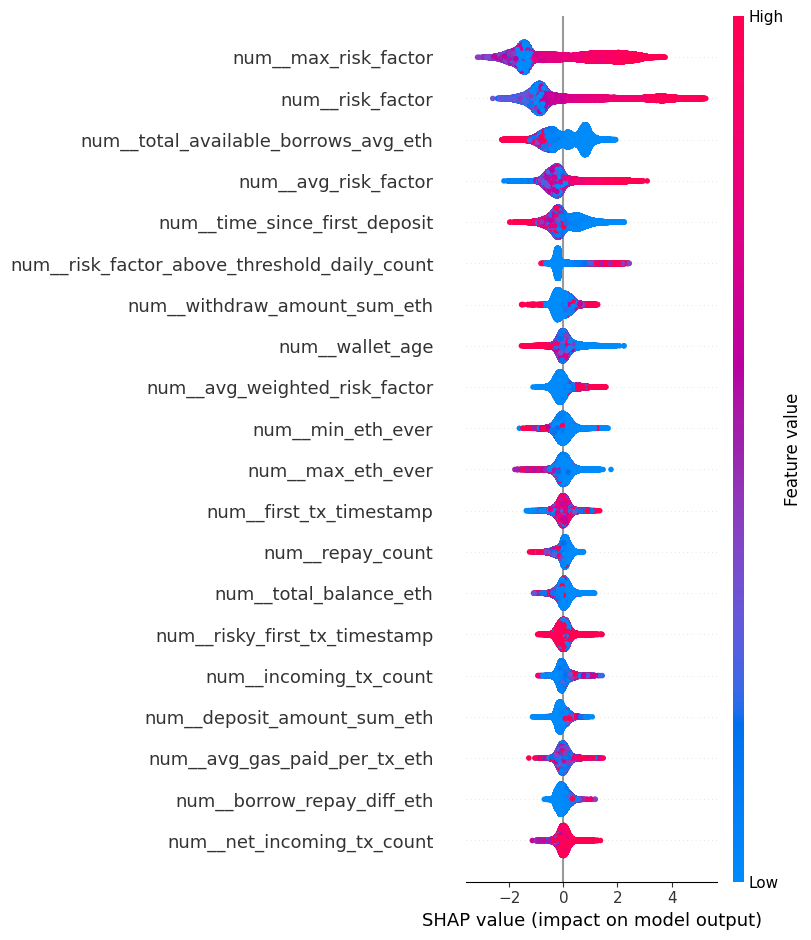

Interpretación para una observación específica (ejemplo: primera fila):


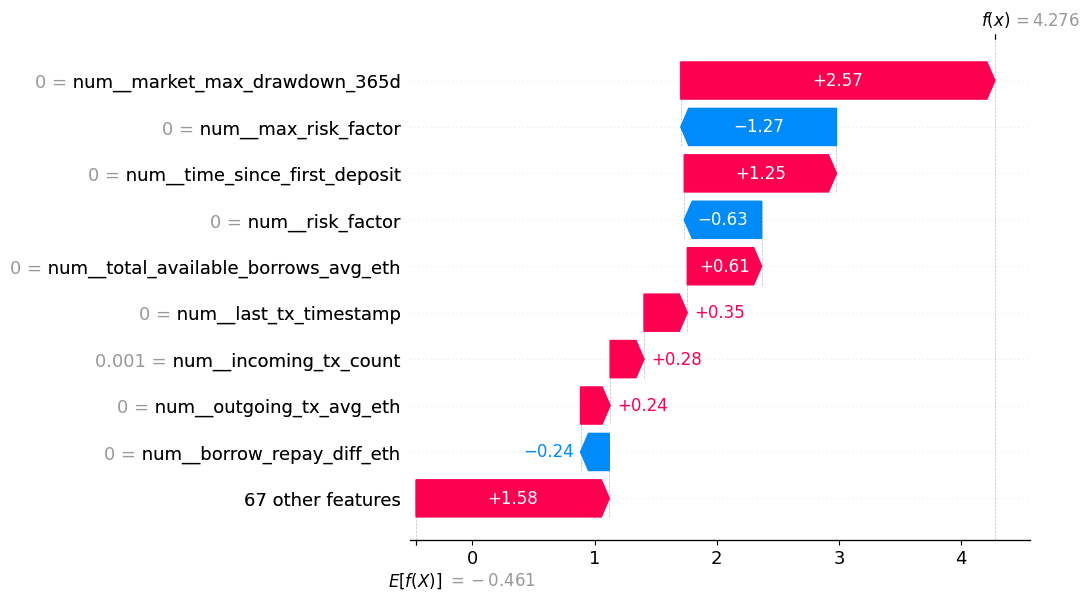

In [ ]:
# Preprocesar los datos antes de aplicar SHAP
df_x_combined_processed = pipeline_xgb_optimizado.named_steps['preprocessing'].transform(df_x_combined)

# Extraer el modelo XGBoost entrenado del pipeline
xgb_model = pipeline_xgb_optimizado.named_steps['xgb_optimizado']

# Aplicar SHAP al modelo entrenado
explainer = shap.Explainer(xgb_model, df_x_combined_processed)

# Calcular los SHAP values para el conjunto de datos procesado
shap_values = explainer(df_x_combined_processed)

# Resumen de SHAP values en forma gráfica
print("Generando gráficos de interpretación con SHAP...")
shap.summary_plot(shap_values, df_x_combined_processed)

print("Interpretación para una observación específica (ejemplo: primera fila):")
shap.waterfall_plot(shap_values[0])

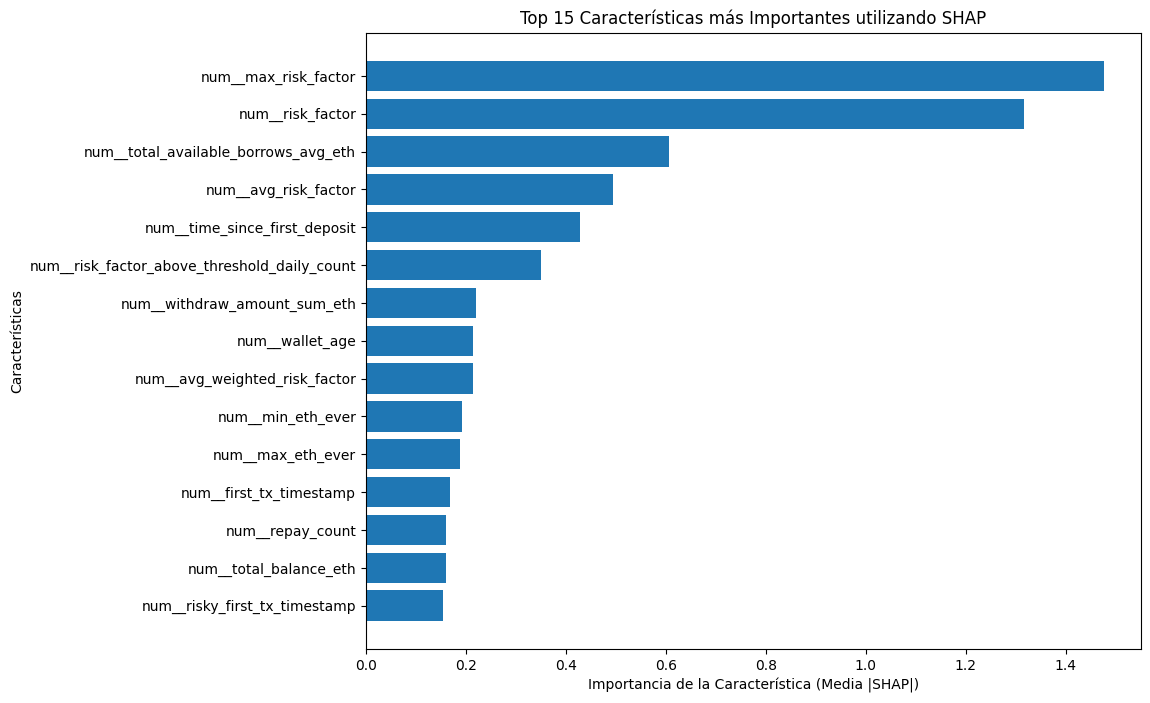

In [46]:
# Calcular la importancia de las características utilizando los SHAP values
shap_values_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Crear un DataFrame con las características y su importancia
importance_df = pd.DataFrame({
    'feature': df_x_combined_processed.columns,  # Nombres de las características originales
    'mean_importance': shap_values_abs_mean
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='mean_importance', ascending=True)

# Seleccionar las 10 características más importantes
top_10_features = importance_df.nlargest(15, 'mean_importance')

# Gráfico de barras horizontales para las 10 características más relevantes
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['feature'], top_10_features['mean_importance'], capsize=5)
plt.xlabel("Importancia de la Característica (Media |SHAP|)")
plt.ylabel("Características")
plt.title("Top 15 Características más Importantes utilizando SHAP")
plt.gca().invert_yaxis()  # Invertir el eje Y para que la característica más importante esté arriba
plt.show()


In [58]:
shap.initjs()

# Ajustar los nombres manualmente si alguna columna ha sido eliminada
processed_features = df_x_combined_processed.columns  

# Asegurarse de que las dimensiones coincidan
assert df_x_combined_processed.shape[1] == shap_values.values.shape[1], "Las dimensiones no coinciden entre datos procesados y SHAP values."

# Visualizar el impacto de las características para una observación específica
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0, :],  # Valores SHAP para la primera observación
    feature_names=processed_features
)


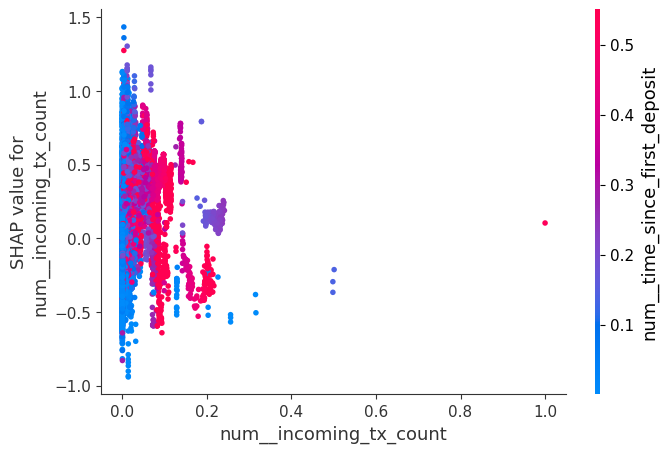

In [ ]:
# Generar un gráfico de dependencia para "num__incoming_tx_count"
shap.dependence_plot(
    "num__incoming_tx_count",
    shap_values.values,  # Extraer los valores SHAP del objeto Explanation
    df_x_combined_processed,  # Conjunto de datos procesado
    feature_names=df_x_combined_processed.columns  
)


In [35]:
def generateFiles(predict_data, clf_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    ---------------
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf

    Ouput
    ---------------
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict_proba(predict_data)[:, 1]
    with open('./predictions.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)
    
    with ZipFile('predictions.zip', 'w') as zipObj:
        zipObj.write('predictions.txt')
    os.remove('predictions.txt')
    
#  Generar predicciones
generateFiles(df_x2, pipeline_xgb_optimizado)